#Comp 767 Assignment 3 Question 3
##Jonathan Pearce
##260672004
##jonathan.pearce@mail.mcgill.ca
https://colab.research.google.com/drive/1EgZmDky4ueZl8qxB8dvzRfDIHfx8QLn8

In [1]:
#Assignment general instructions ask for runtimes in google colab
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=b7bfd57818fc64cb6ce9af559f9297b1e5e4661abba20996c0d7a369fcb3d3db
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [2]:
#imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

time: 1.91 ms


In [3]:
class semi_grad_TD(object):

     #initialize parameters for mountain car
    def __init__(self,seed):
        #set random seed
        np.random.seed(seed)
        #discount factor
        self.discount_factor = 0.99
        #paramater component values
        self.w = np.array([1, 1, 1, 1, 1, 1, 10, 1])
        #step size / learning rate
        self.alpha = 0.01
        #two available actions
        self.solid = 0
        self.dashed = 1
        #feature coeffecients
        self.features = np.zeros([7,8])
        for i in range(6):
            self.features[i,i] = 2
            self.features[i,7] = 1
        self.features[6,6] = 1
        self.features[6,7] = 2


    def policy(self):
        #dashed action - take with probability 6/7
        if np.random.random() < 6.0/7:
            return self.dashed
        #solid action - take with probability 1/7
        else:
            return self.solid

    def step(self,s,a):
        if a == self.dashed:
            #randomly pick from state 0,1,2,3,4,5
            new_state = np.random.randint(6)
        else:
            #go state 6
            new_state = 6

        #return new state and reward
        return new_state,0

    #calculate state value
    #linear combination of feature coefficients and weights
    def value(self,s):
        return np.dot(self.features[s,:],self.w)

    #calculate importance sampling ratio 
    def importance_sampling(self,a):
        #probabilty of all behavour policy actions is 1/7
        b = 1/7.0
        #target policy never takes the dashed action
        if a == self.dashed:
            pi = 0.0
        #target policy always takes the solid action
        else:
            pi = 1.0
        return pi/b


    def semi_grad(self,max_steps):
        #Initialize State
        state = np.random.randint(6)
        #number of steps 
        steps = max_steps
        #time series data
        data = np.zeros([steps,8])
        
        for i in range(steps):
            #select action according to behaviour policy 
            action = self.policy()
            #move to state specified by action
            new_state, reward = self.step(state,action)
            #update component weights
            self.w = self.w + self.alpha * self.importance_sampling(action) * (reward + (self.discount_factor*self.value(new_state)) - self.value(state)) * self.features[state,:]
            #update current state
            state = new_state
            #add current weights to data
            data[i,:] = self.w
        #return data
        return data

time: 63.9 ms


In [4]:
#random seeds
seeds = np.arange(10)
#max steps
max_steps = 1000
#time series data
data = np.zeros([max_steps,8,len(seeds)])


#iterate through random seeds
for i in seeds:
    semi_grad = semi_grad_TD(i)
    #run semi gradient TD(0)
    data[:,:,i] = semi_grad.semi_grad(max_steps)

#calculate mean across random seeds
mean = np.mean(data,axis=2)
#calculate standard deviation across random seeds
std = np.std(data,axis=2)

time: 166 ms


Note: Ran experiment across 10 indepedent random seeds to enable discussion for weight divergence as well as to analyze variance over time.

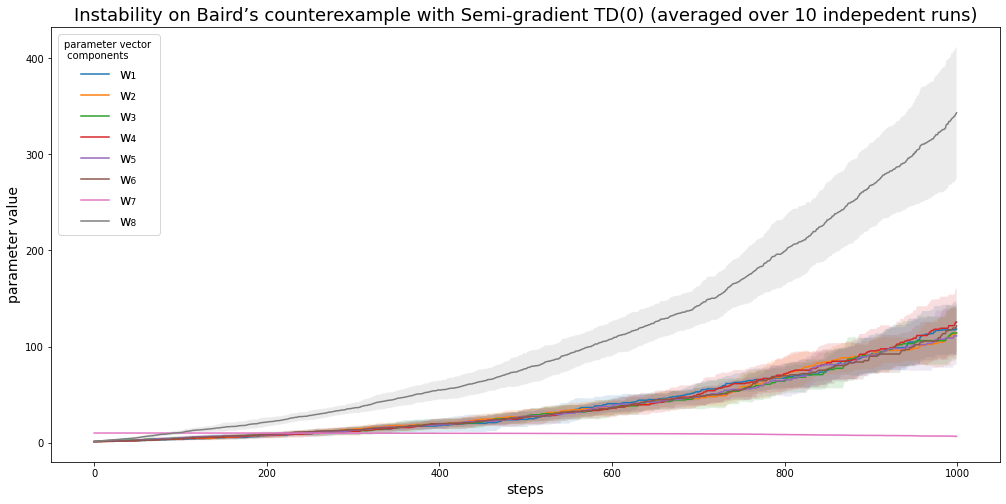

time: 332 ms


In [5]:
plt.figure(figsize=(17,8))
x = np.arange(max_steps)

unicodes = ['\u2081','\u2082','\u2083','\u2084','\u2085','\u2086','\u2087','\u2088']

for i in range(8):
    plt.plot(x,mean[:,i],label='w' + unicodes[i])
    plt.fill_between(x,mean[:,i]-std[:,i],mean[:,i]+std[:,i],alpha=0.15)

plt.title('Instability on Baird’s counterexample with Semi-gradient TD(0) (averaged over 10 indepedent runs)' , fontsize=18)
plt.xlabel('steps',fontsize=14)
plt.ylabel('parameter value',fontsize=14)
plt.legend(loc='upper left',prop={'size': 14},title='parameter vector \n components')
plt.show()


In [6]:
print(mean[-1,:])

[118.25009754 113.72373767 114.08428329 125.45031116 111.10960576
 121.5683489    6.55604402 343.20528019]
time: 1.76 ms


In [7]:
print(std[-1,:])

[27.1083645  26.9476178  27.23985644 34.71273632 30.17057684 25.89710571
  1.24379413 68.87405463]
time: 1.68 ms


In the above experiment we have demonstrated the instability in Baird's counterexample using the semi-gradient TD(0) algorithm. Our parameter values were $\alpha = 0.01$, $\gamma = 0.99$ and initial weights $w = (1, 1, 1, 1, 1, 1, 10, 1)^T$.

The above plot shows how the parameter weights evolve over time. An initial observation is that it appears that all the weights grow without bound, even $w_7$ diverges to negative infinity (confirmed experimentally below). An important note is that the weights only update values when the agent moves to the 7th state because the target policy always takes the solid action and therefore the importance sampling ratio and subsequently the weight updates are only non zero when the agent moves to the 7th state (solid action). Therefore in every case of the weights changing the target value estimate is $\gamma V(7)$. Initially the state value of the first 6 states $V(1),...,V(6)$ = 3 and the value estimate of the 7th state $V(7)$ = 12. When $V(1),...,V(6)$ are lower than $\gamma V(7)$ and $V(7)$ is greater than $\gamma V(7)$, $w_8$ increases 6 times more frequently (on average) than it decreases, leading to rapid increase in value. Similarly $w_1,...,w_6$ increase less frequently (and never decrease) leading to their slower increase in value and $w_7$ is also updated less frequently leading to its slow decrease in value. In theory this constant increase (or decrease) in value implies that $w_1,...,w_6$ and $w_8$ tend to positive infinity and $w_7$ tends to negative infinity. 

###$W_7$ diverges to negative infinity

In [8]:
#random seeds
seeds = np.arange(1)
#max steps
#DIFFERENT NUMBER OF TIMESTEPS TO CONFIRM DIVERGENCE OF ALL WEIGHTS
max_steps = 100000
#time series data
data = np.zeros([max_steps,8,len(seeds)])


#iterate through random seeds
for i in seeds:
    semi_grad = semi_grad_TD(i)
    #run semi gradient TD(0)
    data[:,:,i] = semi_grad.semi_grad(max_steps)

#calculate mean across random seeds
mean = np.mean(data,axis=2)
#calculate standard deviation across random seeds
std = np.std(data,axis=2)

time: 1.45 s


In [9]:
print(mean[-1,:])

[ 9.10107326e+102  8.12623364e+102  9.97904687e+102  8.49148813e+102
  9.92226616e+102  8.19266216e+102 -2.43507181e+101  2.64193707e+103]
time: 2.56 ms


In [10]:
print(mean[-1,6])

-2.4350718147803723e+101
time: 2.32 ms


From above we see that after 100,000 time steps the absolute magintude of all parameters weights is greater than $1e100$, therefore confirming that all weights diverge to infinity and specically that $w_7$ goes to negative infinity, while all other weights tend to positive infinity.